# Node Classification with attri2vec on Citeseer

This is the python implementation of the attri2vec algorithm outlined in paper ***[Attributed Network Embedding Via Subspace Discovery](https://arxiv.org/abs/1901.04095)*** D. Zhang, Y. Jie, X. Zhu and C. Zhang, arXiv:1901.04095, [cs.SI], 2019. The implementation uses the stellargraph libraries.


## attri2vec

attri2vec learns node representations by performing a linear/non-linear mapping on node content attributes. To make the learned node representations respect structural similarity, [`DeepWalk`](https://dl.acm.org/citation.cfm?id=2623732)/[`node2vec`](https://snap.stanford.edu/node2vec) learning mechanism is used to make nodes sharing similar random walk context nodes represented closely in the subspace, which is achieved by maximizing the occurrence probability of context nodes conditioned on the representation of the target nodes. The probability is modelled by Softmax and negative sampling is used to speed up its calculation. This makes attri2vec equivalent to predict whether a node occurs in the given target node's context in random walks with the representation of the target node, by minimizing the cross-entropy loss. 

In implementation, node embeddings are learnt by solving a simple classification task: given a large set of "positive" `(target, context)` node pairs generated from random walks performed on the graph (i.e., node pairs that co-occur within a certain context window in random walks), and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes to node embeddings in a low-dimensional vector space, which preserves structural and feature similarities of the nodes. 

To train the attri2vec model, we first construct a training set of nodes, which is composed of an equal number of positive and negative `(target, context)` pairs from the graph. The positive `(target, context)` pairs are the node pairs co-occurring on random walks over the graph whereas the negative node pairs are the sampled randomly from the global node degree distribution of the graph. In attri2vec, each node is attached with two kinds of embeddings: 1) the inductive 'input embedding', i.e, the objective embedding, obtained by perform a linear/non-linear transformation on node content features, and 2) 'output embedding', i.e., the parameter vector used to predict its occurrence as a context node, obtained by looking up a parameter table. Given a `(target, context)` pair, attri2vec outputs a predictive value to indicate whether it is positive or negative, which is obtained by performing the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node, followed by a sigmoid activation. 

The entire model is trained end-to-end by minimizing the binary cross-entropy loss function with regards to predicted node pair labels and true node pair labels, using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' node pairs generated on demand and fed into the model.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

## Dataset

The dataset is the citation network Citeseer.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/citesser.tgz)

The following is the description of the dataset from the publisher,
> The CiteSeer dataset consists of 3312 scientific publications classified into one of six classes. The citation network consists of 4732 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 3703 unique words. The README file in the dataset provides more details.

Download and unzip the citeseer.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/citeseer/`

where the files `citeseer.cites` and `citeseer.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = "~/data/citeseer"

Load edges in order 'cited-paper' <- 'citing-paper'.

In [3]:
citeseer_location = os.path.expanduser(os.path.join(data_dir, "citeseer.cites"))
g_nx = nx.read_edgelist(path=citeseer_location, create_using=nx.DiGraph()).reverse()

Convert the graph to undirected graph.

In [4]:
g_nx = g_nx.to_undirected()

Load the node attribute data.

In [5]:
citeseer_data_location = os.path.expanduser(os.path.join(data_dir, "citeseer.content"))
attr_names = ["w_{}".format(ii) for ii in range(3703)]
node_column_names = attr_names + ["subject"]
node_attr = pd.read_csv(
    citeseer_data_location, sep="\t", header=None, names=node_column_names
)

Change the type of the indexes of node_attr to str.

In [6]:
node_attr.index = Index(list(map(str, list(node_attr.index))))

The original graph contains some nodes with no attributes. We remove them here.

In [7]:
g_nx = g_nx.subgraph(list(node_attr.index))

Select the largest connected component. For clarity we ignore isolated nodes and subgraphs.

In [8]:
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print(
    "Largest subgraph statistics: {} nodes, {} edges".format(
        g_nx.number_of_nodes(), g_nx.number_of_edges()
    )
)

Largest subgraph statistics: 2110 nodes, 3720 edges


Specify node types.

In [9]:
nx.set_node_attributes(g_nx, "paper", "label")
nx.set_edge_attributes(g_nx, "cites", "label")

Get the ids of the nodes in the selected largest connected component. 

In [10]:
node_ids = sorted(list(g_nx.nodes))

Get node features.

In [11]:
node_features = node_attr[attr_names].reindex(node_ids)

Create the Stellargraph with node features.

In [12]:
G = sg.StellarGraph(g_nx, node_features=node_features)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2110, Edges: 3720

 Node types:
  paper: [2110]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [3720]



## Train attri2vec on Citeseer

Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk.

In [14]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5

Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [15]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

Set the batch size and the number of epochs. 

In [16]:
batch_size = 50
epochs = 4

Define an attri2vec generator, which generates batches of (target, context) nodes and labels for the node pair.

In [17]:
generator = Attri2VecLinkGenerator(G, batch_size)

Building the model: a 1-hidden-layer node representation ('input embedding') of the `target` node and the parameter vector ('output embedding') for predicting the existence of `context node` for each `(target context)` pair, with a link classification layer performed on the dot product of the 'input embedding' of the `target` node and the 'output embedding' of the `context` node.

Attri2Vec part of the model, with a 128-dimenssion hidden layer, no bias term and no normalization. (Normalization can be set to 'l2'). 

In [18]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [19]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.build()

Use the link_classification function to generate the prediction, with the 'ip' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation. 

In [20]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss.

In [21]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [22]:
history = model.fit_generator(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4


1688/1688 - 12s - loss: 0.6833 - binary_accuracy: 0.5560
Epoch 2/4
1688/1688 - 10s - loss: 0.5133 - binary_accuracy: 0.7582
Epoch 3/4
1688/1688 - 10s - loss: 0.3373 - binary_accuracy: 0.8753
Epoch 4/4
1688/1688 - 10s - loss: 0.2469 - binary_accuracy: 0.9164


##  Visualise Node Embeddings

Build the node based model for predicting node representations from node content attributes with the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [23]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings by applying the learned mapping function to node content features.

In [24]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(node_ids)
node_embeddings = embedding_model.predict_generator(node_gen, workers=1, verbose=1)

43/43 [==============================] - 0s 2ms/step


Get node subjects.

In [25]:
node_targets = [node_attr["subject"][node_id] for node_id in node_ids]

Transform the embeddings to 2d space for visualisation.

In [26]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

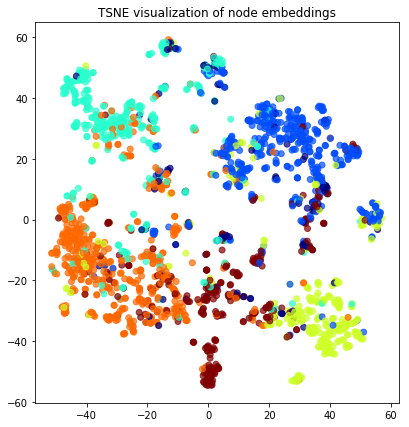

In [27]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Node Classificaion Task

The embeddings learned by `attri2vec` can be used as feature vectors in downstream tasks, such as node classification and link prediction.

In this example, we will use the `attri2vec` node embeddings to train a classifier to predict the subject of a paper in DBLP.

In [28]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

### Data Splitting

We split the data into train and test sets. 

We use 10% of the data for training and the remaining 90% for testing as a hold out test set.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (211, 128)
 y_train = (211,)
 X_test = (1899, 128)
 y_test = (1899,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [30]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

Predict the hold-out test set.

In [31]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [32]:
accuracy_score(y_test, y_pred)

0.7567140600315956